# Análise do Nível de Manutenibilidade
<br>
#### Objetivo:<br>
É importante acompanhar se as issues de correção estão levando mais ou menos tempo, e se o software está com os números de defeitos aumentando ou diminuíndo, ou seja, se a sua modificabilidade está melhorando. Uma boa avaliação desses números é conseguir ter correções mais rápidas e sem efeitos colaterais.
Auxiliar futuras refatorações: Quais devem ser as principais para eliminar problemas;<br>
A partir de uma coleção de métricas coletadas automaticamente e de uma forma objetiva de interpretar seus valores, engenheiros de software podem monitorar características especícas do seu código assim como implementações problemáticas para tomar melhores decisões ao (re)escrevê-las.<br>
<br>
#### Vantagens:<br>
-- Possibilita a rápida identificação de falhas e permite ações de correções na mesma velocidade;<br>
-- O desenvolvimento e a aplicação de novos recursos fica mais fácil e rápido;<br>
-- Há um melhor controle de acesso autorizado para as revisões;<br>
-- Conflitos de mudanças são resolvidos com maior agilidade;<br>
-- Erros e códigos de risco são encontrados mais facilmente;<br>
-- Programadores passam a ter uma visão analítica objetiva, que possibilita e ajuda no reconhecimento de onde os mesmo foram ou não precisos e desatentos;<br>
-- ** Com a exclusão de determinadas classes de defeitos, a equipe se encontra concentrada em outros tipos de eficiência do projeto. **<br>
<br>
Não estou analizando:<br>
-- Complexidade Ciclomática (desvios uma função possui: cada comando if, switch, for, while);<br>
-- Metodos com muitos parâmetros;<br>
-- Outras métricas (Sonar);<br>
<br>
#### Próximos trabalhos:<br>
-- Checkins com uma unit;<br>
-- Cruzar dados do RTC;<br>
<br>


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

arquivos = ['release_changeset_20171.csv', 'HorasPorSalt2017.csv', 'TFS 2017 pas.csv', 'TFS 2017 dfm.csv']
#arquivos = ['release_changeset_2016.csv', 'HorasPorSalt2016.csv', 'TFS 2016 pas.csv', 'TFS 2016 dfm.csv']
#arquivos = ['release_changeset_2013-2015', 'HorasPorSalt2015.csv', 'TFS 2015 pas.csv', 'TFS 2015 dfm.csv']

In [ ]:
dfLinhas = pd.DataFrame({'Metodo' : ['uspjPendenciaPrazo.ConsultaPendencia', 'uspjDBase.ConsultaAtualizacaoInformacoes', 'uspjMensagem.InicializaMensagensSPJ', 'uspjMensagem2.InicializaMensagensSPJ2', 'uspjPendenciaPrazo.AtualizePendencia', 'uspjDocEmitidoServ.OnDepoisSalvarDocumento', 'uspjCDA.OrganizarDadosGeracao', 'uspjProcessoServ.ConsultaProcessoPeloWS', 'uspjPedidoProcurServ.AtualizaPedidoProcurador', 'uspjConsPendenciaPrazoRPdevBasica.PassaParametro', 'uspjCadProcessoMovBase.ccCadastroSpAntesExecutar', 'uspjConsCDA.PreenchaParametrosConsulta', 'uspjAtividadeIndependente.CriarCamposOutrasOperacoes', 'uspjIntimacaoEletServ.ProcessaIntimacao', 'uspjProcessoServ.VerificaConsistenciaProcesso', 'uspjIntimacaoEletServ.ImportarDadosRecebidosWS', 'uspjProcessoMvServ.IncluaMovimentacao'],
                       'Linhas' : [2400, 1100, 1000, 1000, 1000, 900, 800, 800, 700, 700, 650, 580, 550, 540, 500, 500, 500]})
dfLinhas.set_index('Metodo')
print (dfLinhas)

plLinhas = dfLinhas.set_index('Metodo').plot(kind='barh')
plt.title("Número de linhas por método")
plt.show()

print ("*** Algumas fontes a média de linhas por metodo é considerado ruim acima de 13.");


In [ ]:
dfHeadlistPas = pd.read_csv(arquivos[2], encoding='ISO-8859-1', delimiter=',')
#dfHeadlistPas = dfHeadlistPas.drop('cfi', axis=1)
dfHeadlistPas = dfHeadlistPas.query('quantum > 15')
dfHeadlistPas = dfHeadlistPas.assign(file=dfHeadlistPas['itemName'].str.split("/"))
#dfHeadlistPas['file'] = dfHeadlistPas['file'][-1]
#dfHeadlistPas['file'][0][-1]

#f = lambda x: len(x["review"].split("disappointed")) -1
#reviews["disappointed"] = reviews.apply(f, axis=1)

files = []
for row in dfHeadlistPas['itemName']:
    files.append(row.split('/')[-1])
dfHeadlistPas['file'] = files
dfHeadlistPas = dfHeadlistPas.drop('itemName', axis=1).drop('cfi', axis=1)
dfHeadlistPas

In [ ]:
plLinhas = dfHeadlistPas.drop('size', axis=1).set_index('file').plot(kind='barh')
plt.title("Checkins no ano por Unit")
plt.show()

In [ ]:
plLinhas = dfHeadlistPas.drop('quantum', axis=1).sort_values(by='size').set_index('file').plot(kind='barh')
plt.title("Tamanho da Unit")
plt.show()

In [ ]:
dfHeadlistDfm = pd.read_csv(arquivos[3], encoding='ISO-8859-1', delimiter=',')
#dfHeadlistDfm = dfHeadlistPas.drop('cfi', axis=1)
dfHeadlistDfm = dfHeadlistDfm.query('quantum > 2')
dfHeadlistDfm = dfHeadlistDfm.assign(file=dfHeadlistDfm['itemName'].str.split("/"))
#dfHeadlistDfm['file'] = dfHeadlistPas['file'][-1]
#dfHeadlistDfm['file'][0][-1]

#f = lambda x: len(x["review"].split("disappointed")) -1
#reviews["disappointed"] = reviews.apply(f, axis=1)

files = []
for row in dfHeadlistDfm['itemName']:
    files.append(row.split('/')[-1])
dfHeadlistDfm['file'] = files
dfHeadlistDfm = dfHeadlistDfm.drop('itemName', axis=1).drop('cfi', axis=1)
dfHeadlistDfm

In [ ]:
plLinhas = dfHeadlistDfm.drop('size', axis=1).set_index('file').plot(kind='barh')
plt.title("Checkins no ano por dfm")
plt.show()

<http://sonarunj/components/index/9848>

***
### Changeset

Extraido do TFS:<br>
```python
tf hist /noprompt /recursive /format:detailed /version:D"1/1/2015"~D"31/12/2015" $/fPJ/PJ/build/release > 
```


** Utilizado arquivo TFS.ipynb para conversão em CSV.

In [34]:
dfChangesets = pd.read_csv(arquivos[0], encoding='ISO-8859-1', delimiter=';', header=None, 
                 names= ["Salt", "Changeset", "Desenv", "Data", "Descricao", "File", "Filename"])
dfChangesets.head(5)
#df.describe()
#dfChangesets.describe()
#dfChangesets.shape
#dfChangesets.dtypes

,Salt,Changeset,Desenv,Data,Descricao,File,Filename
0,0/0,553789,felipe.caputo,27/12/2017,Implementada invalidação de cache para quando ...,uintCommon.pas,/fPJ/PJ/build/release/4.20/servicepack/pjDev/s...
1,0/0,553789,felipe.caputo,27/12/2017,Implementada invalidação de cache para quando ...,uintWsProcessadorConsultarTeorComunicacao.pas,/fPJ/PJ/build/release/4.20/servicepack/pjDev/s...
2,247275/4,553788,emerson.db1,27/12/2017,SALT 247275/4 - Feature 121967 - [24] - Distri...,dbChange.xml,/fPJ/PJ/build/release/4.20/servicepack/pjDev/d...
3,247275/4,553788,emerson.db1,27/12/2017,SALT 247275/4 - Feature 121967 - [24] - Distri...,PJ011829.DH4,/fPJ/PJ/build/release/4.20/servicepack/pjDev/d...
4,247275/4,553788,emerson.db1,27/12/2017,SALT 247275/4 - Feature 121967 - [24] - Distri...,PJ011829.DH4,/fPJ/PJ/build/release/4.20/servicepack/pjDev/d...


['felipe.caputo' 'emerson.db1' 'robledo.fortuna' 'anderson.albuquerque'
 'darlley.silva' 'nimitz' 'orlando.werner' 'murilo.guollo' 'cassio.roos'
 'andre.langner' 'wilian.ivo' 'juliano' 'carlos.ignacio' 'ulisses.campos'
 'taissiane.moroso' 'guilherme.araujo' 'Rigoni' 'fabio.schunig'
 'valdenir.albino' 'robson.db1' 'roni.beltramin' 'william.colombo' 'versao'
 'luhan.silva' 'gessileini.clinio' 'cesar.pamplona' 'henrique.ramos'
 'rafael.wagner' 'rafael.damasco' 'mathias.silva' 'romulo' 'celio.assis'
 'ulder.junior' 'cesar' 'leandro.vaso' 'maciel.zang' 'rafael.db1'
 'luiz.db1' 'raphael.batista' 'christian.salinas' 'adriane.col'
 'francisco.gomes' 'luiz.faria' 'roberto.junior' 'jefferson.pereira'
 'joel.zurawski' 'joao.taraciuk' 'douglas.zuliani' 'daniel.junior'
 'michelle.sander' 'polegato' 'johnathan.vieira' 'willian.reis']


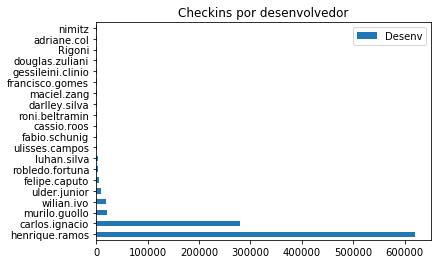

In [3]:
Desenvs = dfChangesets.Desenv.unique()
def GraficoDesenv(df):
    print (Desenvs)
    Files = df.Desenv.value_counts().to_frame() #index #.tolist()
    Files[:20].plot(kind='barh')
    plt.title("Checkins por desenvolvedor")
    plt.show()
    
GraficoDesenv(dfChangesets)

In [35]:
DB1 = ['emerson.db1', 'robson.db1', 'rafael.db1', 'raphael.batista', 'luiz.db1']
Evolucao = ['robledo.fortuna', 'orlando.werner', 'cassio.roos', 'andre.langner', 'juliano', 'guilherme.araujo', 'fabio.schunig' 'ulisses.campos', 'valdenir.albino', 'adriane.col', 'roberto.junior'  'joel.zurawski', 'polegato','rafael.wagner', 'maciel.zang']
Correcao = ['anderson.albuquerque', 'darlley.silva', 'murilo.guollo', 'wilian.ivo', 'gessileini.clinio', 'william.colombo', 'roni.beltramin', 'cesar.pamplona', 'taissiane.moroso', 'douglas.zuliani', 'francisco.gomes'] 
Mni = ['luhan.silva', 'jefferson.pereira', 'felipe.caputo']
Outros = ['nimitz', 'romulo', 'ulder.junior', 'Rigoni']

In [36]:
def Equipe(d): #desenv
    if d in DB1:
        return 'DB1'
    if d in Evolucao:
        return 'Evolucao'
    if d in Correcao:
        return 'Correcao'
    if d in Mni:
        return 'Mni'
    if d in Outros:
        return 'Outros'

dfChangesets['Equipe'] = dfChangesets.Desenv.apply(Equipe)

In [ ]:
#df.groupby('File').count()
#Files = df.File.value_counts()
Files = dfChangesets.File.value_counts().to_frame() #index #.tolist()
Files = Files.filter(like='.pas', axis=0)

Files[:20].plot(kind='barh')
plt.title("Checkins por unit")
plt.show()

# Salts

Dados exportados do SAC via SQL.<br>

> OndeDrive/SAC/Horas.sql
```sql
SELECT DISTINCT 
       ia.NUATENDIMENTO,
       IA.NUITEM,
     ia.NUATENDIMENTO || '/' || IA.NUITEM AS SALT,
       RA.CDORIGEMATEND AS ORIGEM,
       --ra.NUSEQVERSAO,
       ve.NURELEASE,
       /*(SELECT COUNT(1)
                 FROM SAC.ESACATIVIDADE AA
                WHERE AA.CDPROJETO = IA.CDPROJETO
                  AND AA.NUATENDIMENTO = IA.NUATENDIMENTO
                  AND AA.NUITEM = IA.NUITEM
                  AND AA.CDTIPOATIVIDADE = 120) AS PRIORIDADES_SOLICITADAS,
       CASE WHEN IA.DTLIMSOLUCAO < CURRENT DATE THEN 'VENCIDA' ELSE 'DENTRO_PRAZO' END SITUACAO_SLA,*/
       CLI.SGCLIENTE AS CLIENTE,
       IA.DTREGISTRO AS DATA_CADASTRO,
       IA.DTLIMSOLUCAO AS DATA_SLA,
       CASE IA.CDPRIORIDADE 
         WHEN 6 THEN 'ZERO/CRÍTICA'
         WHEN 5 THEN 'UM/IMPEDITIVA'
         WHEN 1 THEN 'DOIS/ALTA'
         WHEN 2 THEN 'TRES/MÉDIA'
         WHEN 3 THEN 'QUATRO/BAIXA'
         WHEN 4 THEN 'INDEFINIDA'
       END SEVERIDADE,
       CASE IA.CDPRIORIDADE 
         WHEN 6 THEN 8
         WHEN 5 THEN 5
         WHEN 1 THEN 4
         WHEN 2 THEN 3
         WHEN 3 THEN 2
         WHEN 4 THEN 3
       END PONTUACAO_SEVERIDADE,
       SIT.DESITUACAOATEND AS SITUACAO_SALT,
       /*CASE WHEN (SELECT COUNT(1)
                 FROM SAC.ESACATIVIDADE AA
                WHERE AA.CDPROJETO = IA.CDPROJETO
                  AND AA.NUATENDIMENTO = IA.NUATENDIMENTO
                  AND AA.NUITEM = IA.NUITEM
                  AND AA.CDTIPOATIVIDADE IN (243,303)) > 0 THEN 'SIM' ELSE 'NÃO' END AS REJEITE,*/
       AA.NUSEQATIVIDADE,
       AA.CDTIPOATIVIDADE,
       TA.DETIPOATIVIDADE,
       AA.DTREALINICIO,
       AA.DTREALFINAL,
       '0' || CAST(AA.QTHORASREAL AS VARCHAR(10)) AS QTHORASREAL,
    (SELECT '0' || CAST(SUM(AA.QTHORASREAL) AS VARCHAR(10))
                 FROM SAC.ESACATIVIDADE AA
                WHERE AA.CDPROJETO = IA.CDPROJETO
                  AND AA.NUATENDIMENTO = IA.NUATENDIMENTO
                  AND AA.NUITEM = IA.NUITEM
                  --AND AA.CDTIPOATIVIDADE IN (243,303)
                  ) AS HORASTOTAIS
  FROM sac.ESACREGISTROATEND ra
 LEFT JOIN sac.ESACVERSAO ve
    ON ra.CDPROJETO = ve.CDPROJETO
   AND ra.CDSISTEMA = ve.CDSISTEMA
   AND ra.NUSEQVERSAO = ve.NUSEQVERSAO
  JOIN sac.ESACITEMATEND ia
    ON ia.cdProjeto = ia.CDPROJETO
   AND ia.NUATENDIMENTO = ra.NUATENDIMENTO
  JOIN SAC.ESACSITUACAOATEND SIT
    ON SIT.CDSITUACAOATEND = IA.CDSITUACAOATEND
  JOIN sac.ESACATIVIDADE a
    ON a.cdProjeto = ia.CDPROJETO
   AND a.NUATENDIMENTO = ia.NUATENDIMENTO
   AND a.NUITEM = ia.NUITEM
   AND a.CDTIPOATIVIDADE in (162)
  JOIN SAC.ESACCLIENTE CLI
    ON CLI.CDCLIENTE = ra.CDCLIENTE    
  JOIN SAC.ESACATIVIDADE AA
    ON AA.CDPROJETO = IA.CDPROJETO
   AND AA.NUATENDIMENTO = IA.NUATENDIMENTO
   AND AA.NUITEM = IA.NUITEM    
 LEFT  JOIN SAC.ESACTIPOATIVIDADE TA
    ON AA.CDTIPOATIVIDADE = TA.CDTIPOATIVIDADE
 WHERE ra.cdProjeto = 3
--   AND ra.CDORIGEMATEND = 10
   AND ra.CDSISTEMA IN (31,93)
--   AND ra.CDCLIENTE <> 3969
--   AND a.DTENCERRAMENTO IS NULL
--   AND ia.DTLIMSOLUCAO IS NOT NULL
--   AND SIT.CDSITUACAOATEND=65
   AND VARCHAR_FORMAT (ia.DTREGISTRO,'YYYY-MM-DD') > '2017-01-01'
--AND ra.NUATENDIMENTO = 263466
ORDER BY ia.NUATENDIMENTO, IA.NUITEM, AA.NUSEQATIVIDADE
```


In [3]:
dfSalts = pd.read_csv(arquivos[1], encoding='ISO-8859-1', delimiter=',')
dfSalts

,NUATENDIMENTO,NUITEM,SALT,ORIGEM,NURELEASE,CLIENTE,DATA_CADASTRO,DATA_SLA,SEVERIDADE,PONTUACAO_SEVERIDADE,SITUACAO_SALT,NUSEQATIVIDADE,CDTIPOATIVIDADE,DETIPOATIVIDADE,DTREALINICIO,DTREALFINAL,QTHORASREAL,HORASTOTAIS
0,4,2,4/2,8,3020100,EQUIPE-SAJ,2017-03-02 16:59:16,NaN,UM/IMPEDITIVA,5,Pendente,1,310,Apontamento de Horas,2017-03-02,2017-03-02,16.0,16.0
1,1000,1,1000/1,8,3030101,EQUIPE-SAJ,2017-05-11 13:39:16,NaN,INDEFINIDA,3,Encerrado,2,16,Avaliação do atendimento,2017-05-11,2017-05-11,750.0,750.0
2,1000,1,1000/1,8,3030101,EQUIPE-SAJ,2017-01-18 12:03:04,NaN,DOIS/ALTA,4,Encerrado,2,16,Avaliação do atendimento,2017-01-18 17:46:04,2017-01-18 17:46:04,3500.0,4500.0
3,1000,1,1000/1,8,3030101,EQUIPE-SAJ,2017-01-18 12:03:04,NaN,DOIS/ALTA,4,Encerrado,3,283,Revisão de código,2017-01-18,2017-01-18,1000.0,4500.0
4,1003,1,1003/1,8,3030101,EQUIPE-SAJ,2017-05-11 16:46:57,NaN,INDEFINIDA,3,Encerrado,2,16,Avaliação do atendimento,2017-05-11,2017-05-11,750.0,750.0
5,1003,1,1003/1,8,3030101,EQUIPE-SAJ,2017-01-20 15:21:58,NaN,UM/IMPEDITIVA,5,Encerrado,2,16,Avaliação do atendimento,2017-02-01,2017-02-01,1000.0,1000.0
6,12110,1,12110/1,8,2000000,EQUIPE-SAJ,2017-04-03 10:11:10,NaN,INDEFINIDA,3,Encerrado,1,16,Avaliação do atendimento,2017-04-05,2017-04-05,16.0,16.0
7,12117,1,12117/1,8,2000001,EQUIPE-SAJ,2017-04-26 16:06:22,NaN,TRES/MÉDIA,3,Encerrado,1,918,Atendimento ao Cliente/Suporte,2017-04-26 16:08:14,2017-04-26 16:08:14,500.0,500.0
8,12149,1,12149/1,10,1000304,PGE/PB,2017-10-25 15:02:54,2017-10-31 15:01:59,INDEFINIDA,3,Encerrado,1,918,Atendimento ao Cliente/Suporte,2017-10-20 15:03:47,2017-10-20 15:03:47,1000.0,1000.0
9,54056,1,54056/1,10,3030704,PGE/SP,5006-08-31,NaN,TRES/MÉDIA,3,Encerrado,1,77,Cadastro do atendimento,2006-09-04,2006-09-04,116.0,449.0


In [ ]:
Salts = dfChangesets.Salt.value_counts().to_frame() #index #.tolist()
#Files[:20].plot(kind='barh')
#Files = Files.filter(like='.pas', axis=0)

Salts[:20].plot(kind='barh')
plt.title("Checkins por Salt")
plt.show()

In [ ]:
Salts = dfChangesets.Salt.value_counts()#.to_frame()
Salts = Salts.loc[Salts>1050]
Salts = Salts.to_frame().reset_index()
Salts = Salts.drop('Salt', axis=1)
Salts = Salts.set_index("index")
Salts

In [37]:
Salts_counts = dfChangesets.Salt.value_counts()
#Salts_uniques = dfChangesets.Salt.unique()#.to_frame()

dfChangesets['conta'] = dfChangesets.Salt.apply(lambda y: 1 if y not in Salts_counts else Salts_counts[y])
dfChangesets['apagar'] = dfChangesets.conta.apply(lambda y: True if y>1050 else False)

In [38]:
dfChangesets = dfChangesets[dfChangesets.apagar == False]

In [39]:
GraficoDesenv(dfChangesets)

NameError: name 'GraficoDesenv' is not defined

In [ ]:
dfChangesets.groupby('Salt')['Salt'].count()

In [ ]:
#dfChangesets['conta'] = 1
#dfChangesets['conta'] = dfChangesets.groupby('Salt')['Salt'].count()
dfChangesets.groupby('Salt')['Salt'].count()

In [40]:
dfChangesets.head(30)

,Salt,Changeset,Desenv,Data,Descricao,File,Filename,Equipe,conta,apagar
2,247275/4,553788,emerson.db1,27/12/2017,SALT 247275/4 - Feature 121967 - [24] - Distri...,dbChange.xml,/fPJ/PJ/build/release/4.20/servicepack/pjDev/d...,DB1,55,False
3,247275/4,553788,emerson.db1,27/12/2017,SALT 247275/4 - Feature 121967 - [24] - Distri...,PJ011829.DH4,/fPJ/PJ/build/release/4.20/servicepack/pjDev/d...,DB1,55,False
4,247275/4,553788,emerson.db1,27/12/2017,SALT 247275/4 - Feature 121967 - [24] - Distri...,PJ011829.DH4,/fPJ/PJ/build/release/4.20/servicepack/pjDev/d...,DB1,55,False
5,247275/4,553788,emerson.db1,27/12/2017,SALT 247275/4 - Feature 121967 - [24] - Distri...,PJ011829.DH4,/fPJ/PJ/build/release/4.20/servicepack/pjDev/d...,DB1,55,False
6,247275/4,553788,emerson.db1,27/12/2017,SALT 247275/4 - Feature 121967 - [24] - Distri...,uspjCadConfiguracaoProcAdministrativosPrecator...,/fPJ/PJ/build/release/4.20/servicepack/pjDev/s...,DB1,55,False
7,247275/4,553788,emerson.db1,27/12/2017,SALT 247275/4 - Feature 121967 - [24] - Distri...,uspjCadConfiguracaoProcAdministrativosPrecator...,/fPJ/PJ/build/release/4.20/servicepack/pjDev/s...,DB1,55,False
8,247275/4,553788,emerson.db1,27/12/2017,SALT 247275/4 - Feature 121967 - [24] - Distri...,uspjCadCriterioDistComOrgao.dfm,/fPJ/PJ/build/release/4.20/servicepack/pjDev/s...,DB1,55,False
9,247275/4,553788,emerson.db1,27/12/2017,SALT 247275/4 - Feature 121967 - [24] - Distri...,uspjCadCriterioDistComOrgao.pas,/fPJ/PJ/build/release/4.20/servicepack/pjDev/s...,DB1,55,False
10,247275/4,553788,emerson.db1,27/12/2017,SALT 247275/4 - Feature 121967 - [24] - Distri...,uspjCadProcessoAdmMov.pas,/fPJ/PJ/build/release/4.20/servicepack/pjDev/s...,DB1,55,False
11,247275/4,553788,emerson.db1,27/12/2017,SALT 247275/4 - Feature 121967 - [24] - Distri...,uspjConsultaAcordosPrecatorioNaoProcessados.dfm,/fPJ/PJ/build/release/4.20/servicepack/pjDev/s...,DB1,55,False


In [31]:
dfAtividades = dfSalts.groupby(['CDTIPOATIVIDADE', 'DETIPOATIVIDADE'])['SALT'].count().to_frame().sort_values(by='SALT', ascending=False)
dfAtividades = [83, 162, 51, 188, 90, 336, 8, 45, 119, 15, 344]
#dfAtividades.Codigo.value_counts
#083	Determinacao das Causas Possiveis
#162	Avalicao atendimento - Correcao
#051	Sincronizacao de fontes para versao de correcao
#188	Avaliacao atendimento - Desenvolvimento PJ
#090	Suporte e apoio t้cnico ao cliente interno
#336	Codificar solucao
#008	Codificacao
#045	Codificacao devido a testes reprovados
#119	Avaliacao atendimento - Desenvolvimento
#015	Script
#344	Corrigir codificacao

dfSalts['AtividadeDesenv'] = dfSalts.CDTIPOATIVIDADE.apply(lambda y: True if y in dfAtividades else False)
#dfSalts['HorasDesenv'] = dfSalts.AtividadeDesenv.apply(lambda y: dfSalts.QTHORASREAL if y == True else 0) #Pupilo
#dfSalts['HorasDesenv'] = 0.00
#dfSalts[dfSalts.AtividadeDesenv == True].HorasDesenv = dfSalts.QTHORASREAL #Pupilo
dfSalts.HorasDesenv = dfSalts.QTHORASREAL
#dfSalts['HorasDesenv'] = dfSalts['AtividadeDesenv', 'QTHORASREAL'].apply(lambda Ativ, Horas: 0 if Ativ == False else Horas)
dfSalts[dfSalts.AtividadeDesenv == True]

,NUATENDIMENTO,NUITEM,SALT,ORIGEM,NURELEASE,CLIENTE,DATA_CADASTRO,DATA_SLA,SEVERIDADE,PONTUACAO_SEVERIDADE,SITUACAO_SALT,NUSEQATIVIDADE,CDTIPOATIVIDADE,DETIPOATIVIDADE,DTREALINICIO,DTREALFINAL,QTHORASREAL,HORASTOTAIS,AtividadeDesenv,HorasDesenv
14,54529,1,54529/1,10,3030900,PGE/ES,2017-01-19 14:37:44,NaN,DOIS/ALTA,4,Encerrado,1,8,Codificação,2017-01-19 16:51:31,2017-02-14 16:15:59,33250.0,33250.0,True,33250.0
15,54531,1,54531/1,10,3030900,PGE/ES,2017-01-19 16:30:26,NaN,DOIS/ALTA,4,Encerrado,1,8,Codificação,2017-01-19 16:31:46,2017-01-24 09:07:15,6250.0,6250.0,True,6250.0
20,54545,1,54545/1,8,3030101,EQUIPE-SAJ,2017-01-31 17:24:54,NaN,DOIS/ALTA,4,Encerrado,1,8,Codificação,2017-01-31 17:28:48,2017-02-14 16:18:00,2250.0,2250.0,True,2250.0
27,54551,1,54551/1,10,3030801,PGE/PE,2017-02-01 14:29:52,NaN,TRES/MÉDIA,3,Encerrado,1,8,Codificação,2017-02-02 08:19:16,2017-02-03 08:19:16,16000.0,16000.0,True,16000.0
31,54562,1,54562/1,10,3030801,PGE/PE,2017-02-10 14:53:18,2017-04-03 14:59:58,DOIS/ALTA,4,Encerrado,4,8,Codificação,2017-03-22 09:59:20,2017-03-31 09:49:14,13916.0,18265.0,True,13916.0
33,54565,1,54565/1,10,3030900,PGE/ES,2017-02-13 16:41:13,NaN,DOIS/ALTA,4,Encerrado,1,8,Codificação,2017-02-07 16:43:25,2017-02-10 16:44:50,28833.0,28833.0,True,28833.0
37,54595,1,54595/1,10,3030900,PGE/ES,2017-03-03 08:13:45,2017-03-09 18:00:00,TRES/MÉDIA,3,Encerrado,1,90,Suporte e apoio técnico ao cliente interno,2017-03-02 08:19:14,2017-03-07 11:44:55,416.0,416.0,True,416.0
43,54598,1,54598/1,8,3030101,EQUIPE-SAJ,2017-03-03 15:01:27,NaN,TRES/MÉDIA,3,Encerrado,4,8,Codificação,2017-03-08 14:10:36,2017-03-08 14:14:26,4083.0,5432.0,True,4083.0
52,54623,1,54623/1,10,3030704,PGE/SP,2017-03-16 09:57:24,2017-03-20 18:00:00,DOIS/ALTA,4,Encerrado,1,8,Codificação,2017-03-16 09:59:20,2017-03-16 09:59:20,2000.0,2000.0,True,2000.0
58,54632,1,54632/1,10,3030900,PGE/ES,2017-03-24 11:08:32,NaN,TRES/MÉDIA,3,Encerrado,1,8,Codificação,2017-03-24 08:24:11,2017-03-31 07:53:18,16500.0,17583.0,True,16500.0


In [64]:
dfSalts['PerdeuPrazoSla'] = dfSalts.NUATENDIMENTO % 2 == 0
dfSalts.head(5)

,NUATENDIMENTO,NUITEM,SALT,ORIGEM,NURELEASE,CLIENTE,DATA_CADASTRO,DATA_SLA,SEVERIDADE,PONTUACAO_SEVERIDADE,...,CDTIPOATIVIDADE,DETIPOATIVIDADE,DTREALINICIO,DTREALFINAL,QTHORASREAL,HORASTOTAIS,AtividadeDesenv,HorasDesenv,Salt,PerdeuPrazoSla
0,4,2,4/2,8,3020100,EQUIPE-SAJ,2017-03-02 16:59:16,NaN,UM/IMPEDITIVA,5,...,310,Apontamento de Horas,2017-03-02,2017-03-02,16.0,16.0,False,16.0,4/2,True
1,1000,1,1000/1,8,3030101,EQUIPE-SAJ,2017-05-11 13:39:16,NaN,INDEFINIDA,3,...,16,Avaliação do atendimento,2017-05-11,2017-05-11,750.0,750.0,False,750.0,1000/1,True
2,1000,1,1000/1,8,3030101,EQUIPE-SAJ,2017-01-18 12:03:04,NaN,DOIS/ALTA,4,...,16,Avaliação do atendimento,2017-01-18 17:46:04,2017-01-18 17:46:04,3500.0,4500.0,False,3500.0,1000/1,True
3,1000,1,1000/1,8,3030101,EQUIPE-SAJ,2017-01-18 12:03:04,NaN,DOIS/ALTA,4,...,283,Revisão de código,2017-01-18,2017-01-18,1000.0,4500.0,False,1000.0,1000/1,True
4,1003,1,1003/1,8,3030101,EQUIPE-SAJ,2017-05-11 16:46:57,NaN,INDEFINIDA,3,...,16,Avaliação do atendimento,2017-05-11,2017-05-11,750.0,750.0,False,750.0,1003/1,False


In [65]:
dfSalts['Salt'] = dfSalts.SALT
#dfChangesets = dfChangesets.merge(dfSalts[['Salt','HORASTOTAIS']], how='right', on='Salt')
dfChangesets = dfChangesets.merge(dfSalts[dfSalts.AtividadeDesenv == True][['Salt','HORASTOTAIS', 'PerdeuPrazoSla']], how='right', on='Salt') #Pupilo

In [42]:
dfChangesets.query('conta > 1')

,Salt,Changeset,Desenv,Data,Descricao,File,Filename,Equipe,conta,apagar,HORASTOTAIS
0,247275/3,553787.0,emerson.db1,27/12/2017,SALT 247275/3 - Script PJ12028-X.sql,dbChange.xml,/fPJ/PJ/build/release/4.20/servicepack/pjDev/d...,DB1,47.0,False,3309.0
1,247275/3,553787.0,emerson.db1,27/12/2017,SALT 247275/3 - Script PJ12028-X.sql,PJ011728.DH4,/fPJ/PJ/build/release/4.20/servicepack/pjDev/d...,DB1,47.0,False,3309.0
2,247275/3,553787.0,emerson.db1,27/12/2017,SALT 247275/3 - Script PJ12028-X.sql,PJ011728.DH4,/fPJ/PJ/build/release/4.20/servicepack/pjDev/d...,DB1,47.0,False,3309.0
3,247275/3,553787.0,emerson.db1,27/12/2017,SALT 247275/3 - Script PJ12028-X.sql,PJ011728.DH4,/fPJ/PJ/build/release/4.20/servicepack/pjDev/d...,DB1,47.0,False,3309.0
4,247275/3,553785.0,emerson.db1,27/12/2017,SALT 247275/3 - Script PJ12021-X.sql,PJ011727.DH4,/fPJ/PJ/build/release/4.20/servicepack/pjDev/d...,DB1,47.0,False,3309.0
5,247275/3,553785.0,emerson.db1,27/12/2017,SALT 247275/3 - Script PJ12021-X.sql,PJ011727.DH4,/fPJ/PJ/build/release/4.20/servicepack/pjDev/d...,DB1,47.0,False,3309.0
6,247275/3,553784.0,emerson.db1,27/12/2017,SALT 247275/3 - Script PJ12021-X.sql,dbChange.xml,/fPJ/PJ/build/release/4.20/servicepack/pjDev/d...,DB1,47.0,False,3309.0
7,247275/3,553784.0,emerson.db1,27/12/2017,SALT 247275/3 - Script PJ12021-X.sql,PJ011727.DH4,/fPJ/PJ/build/release/4.20/servicepack/pjDev/d...,DB1,47.0,False,3309.0
8,247275/3,553784.0,emerson.db1,27/12/2017,SALT 247275/3 - Script PJ12021-X.sql,PJ011727.DH4,/fPJ/PJ/build/release/4.20/servicepack/pjDev/d...,DB1,47.0,False,3309.0
9,247275/3,553784.0,emerson.db1,27/12/2017,SALT 247275/3 - Script PJ12021-X.sql,PJ011727.DH4,/fPJ/PJ/build/release/4.20/servicepack/pjDev/d...,DB1,47.0,False,3309.0


In [43]:
dfChangesets['Media'] = dfChangesets.HORASTOTAIS / dfChangesets.conta

In [47]:
HorasFile = dfChangesets[dfChangesets.Equipe == 'Correcao'].groupby('File', as_index=False).agg({"Media": "mean"})
HorasFile = HorasFile.sort_values(by='Media', ascending=False)
HorasFile#.head(100)

,File,Media
200,uspjCda.pas,72351.500000
143,uspjArvoreAssunto.pas,15847.000000
210,uspjClassificaPublicacao.pas,15566.391304
41,spjAdmClienteApp.dpr,14334.047619
330,uspjDocumentoSPJ.pas,12887.575487
83,uedtCategoriaCons.dfm,12326.000000
171,uspjCadMovPublicacao.pas,11632.000000
456,uspjPessoaDocServ.pas,10149.272727
485,uspjPropriedadesDistribuicaoDevedor.pas,9956.000000
471,uspjProcessoParte.pas,9523.000000


In [45]:
correcao = dfChangesets[dfChangesets.Equipe == 'Correcao']
correcao[correcao.File == 'uspjEnvioEMail.pas']
#correcao[correcao.Salt == '260601/1']

,Salt,Changeset,Desenv,Data,Descricao,File,Filename,Equipe,conta,apagar,HORASTOTAIS,Media
5242,260601/1,551248.0,anderson.albuquerque,7/12/2017,SALT 260601/1 - Correção no envio de email de ...,uspjEnvioEMail.pas,/fPJ/PJ/build/release/4.0.18/USP/pjDev/src/pj/...,Correcao,7.0,False,61447.0,8778.142857
5249,260601/1,551248.0,anderson.albuquerque,7/12/2017,SALT 260601/1 - Correção no envio de email de ...,uspjEnvioEMail.pas,/fPJ/PJ/build/release/4.0.18/USP/pjDev/src/pj/...,Correcao,7.0,False,61447.0,8778.142857
5256,260601/1,551248.0,anderson.albuquerque,7/12/2017,SALT 260601/1 - Correção no envio de email de ...,uspjEnvioEMail.pas,/fPJ/PJ/build/release/4.0.18/USP/pjDev/src/pj/...,Correcao,7.0,False,61447.0,8778.142857


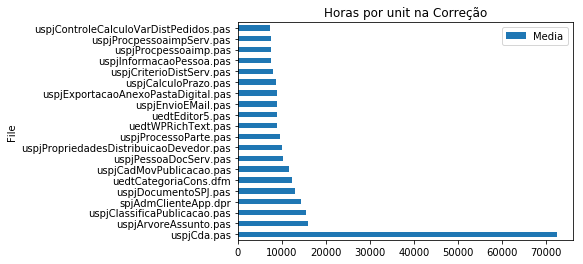

In [50]:
HorasFile[:20].set_index('File').plot(kind='barh')
plt.title("Horas por unit na Correção")
plt.show()

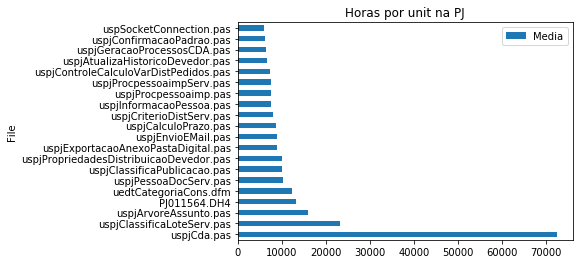

In [51]:
HorasTotal = dfChangesets.groupby('File', as_index=False).agg({"Media": "mean"})
HorasTotal = HorasTotal.sort_values(by='Media', ascending=False)

HorasTotal[:20].set_index('File').plot(kind='barh')
plt.title("Horas por unit na PJ")
plt.show()


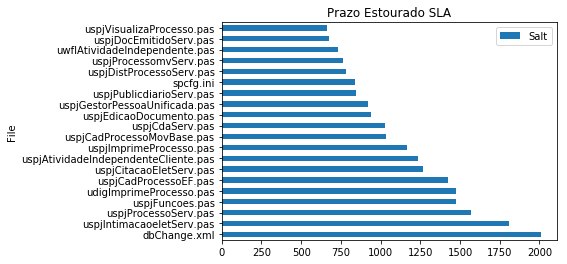

In [70]:
Prazo = dfChangesets[dfChangesets.PerdeuPrazoSla == True].groupby('File', as_index=False).agg({"Salt": "count"})
Prazo = Prazo.sort_values(by='Salt', ascending=False)
Prazo.head(10)

Prazo[:20].set_index('File').plot(kind='barh')
plt.title("Prazo Estourado SLA")
plt.show() #Pupilo

In [ ]:
#Salts por por severidade por unit

PONTUACAO_SEVERIDADE

In [ ]:
#filtrar os defects e corrigir com o número da salt (também remove salts NaN)
#para isso gerar um arquivo no RTC: defect|salt|colaborador|horas

#dfChangesetsArray = dfChangesets
#dfChangesetsArray.set_index('Salt');
#dfChangesets[(dfChangesetsArray.Salt[:6] == 'Defect')]
#dfChangesets = dfChangesetsArray.mask(lambda x: x['Salt'][:6] == 'Defect')
#dfChangesets = dfChangesetsArray.Salt.str.contains('Defect')
#dfChangesets = dfChangesetsArray.Salt.str.startswith( )
#dfChangesetsArray = dfChangesetsArray.Salt.str.contains('/')